# Importing Packages and Basic Parameters

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import tf2onnx
import onnxruntime as rt
import librosa
import soundfile as sf
# import random as rn

from scipy import stats
from os import listdir
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Average, Concatenate, GRU, Bidirectional, LeakyReLU, Dense, Dropout, Input, Convolution1D, Layer, Add
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error, binary_crossentropy 
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
# import sr_ecg
random_seed = 34
batch_size = 64
# num_classes = 1
epochs = 100
#decide the GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# #target ECG leads to train
# TargetLead = [0,1,2]
#Designate the CPSC2018 data set to load
data_folder_path = './solicited/'
# data_folder_path2 = './TrainingSet2/'
# data_folder_path3 = './TrainingSet3/'

In [3]:
def keras_2_onnx(model, modelName):
    out_path = modelName + ".onnx"
    spec = (tf.TensorSpec((None, 22050, 1), tf.float32, name="input"),)
    spec2 = (tf.TensorSpec((None, 27), tf.float32, name="input2"),)
    m_proto, _ = tf2onnx.convert.from_keras(model, input_signature=[spec, spec2], output_path=out_path)
    
    out_name = [n.name for n in m_proto.graph.output]
    return out_name

def get_prediction(val_X, modelName):
    model_inference = rt.InferenceSession(modelName + ".onnx")
    
    input_name = model_inference.get_inputs()[0].name
    input_name2 = model_inference.get_inputs()[1].name
    label_name = model_inference.get_outputs()[0].name
    label_name2 = model_inference.get_outputs()[1].name
    onnx_pred = model_inference.run([label_name, label_name2], {input_name: val_X[0].astype(np.float32), input_name2: val_X[1].astype(np.float32)})
    # pred = np.argmax(onnx_pred[0], axis=1)
    return onnx_pred

def get_prediction2(val_X, modelName):
    model_inference = rt.InferenceSession(modelName + ".onnx")
    
    input_name = model_inference.get_inputs()[0].name
    input_name2 = model_inference.get_inputs()[1].name
    onnx_pred = model_inference.run(['output'], {input_name: val_X[0].astype(np.float32), input_name2: val_X[1].astype(np.float32)})
    # pred = np.argmax(onnx_pred[0], axis=1)
    return onnx_pred[0]

# CPU and GPU Checking

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Combining

In [ ]:
TrainTable1 = pd.read_csv('./CODA_TB_Clinical_Meta_Info.csv')
TrainTable2 = pd.read_csv('./CODA_TB_Solicited_Meta_Info.csv')
TrainTable = pd.merge(TrainTable2, TrainTable1, on="participant")

In [ ]:
TrainTable.columns

Index(['participant', 'filename', 'sound_prediction_score', 'sex', 'age',
       'height', 'weight', 'reported_cough_dur', 'tb_prior', 'tb_prior_Pul',
       'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis', 'heart_rate',
       'temperature', 'weight_loss', 'smoke_lweek', 'fever', 'night_sweats',
       'tb_status'],
      dtype='object')

In [ ]:
numerical = TrainTable[['filename', 'participant', 'tb_status','sound_prediction_score', 'age', 'height', 'weight', 'reported_cough_dur', 'heart_rate',
       'temperature']].copy()
categorical = TrainTable[['sex', 'tb_prior', 'tb_prior_Pul',
       'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis', 'weight_loss', 'smoke_lweek', 'fever', 'night_sweats', 'participant']].copy()
categorical = pd.get_dummies(categorical).copy()
categorical['filename'] = TrainTable['filename']

In [ ]:
TrainTable = pd.merge(numerical, categorical, on="filename")
TrainTable.head()

,filename,participant,tb_status,sound_prediction_score,age,height,weight,reported_cough_dur,heart_rate,temperature,...,participant_CODA_TB_1098,participant_CODA_TB_1099,participant_CODA_TB_1100,participant_CODA_TB_1101,participant_CODA_TB_1102,participant_CODA_TB_1103,participant_CODA_TB_1104,participant_CODA_TB_1105,participant_CODA_TB_1106,participant_CODA_TB_1107
0,1645088710003-recording-1.wav,CODA_TB_0001,0,0.990254,27,173.3,63.0,30,99,37.2,...,0,0,0,0,0,0,0,0,0,0
1,1645088760390-recording-1.wav,CODA_TB_0001,0,0.990272,27,173.3,63.0,30,99,37.2,...,0,0,0,0,0,0,0,0,0,0
2,1645088760830-recording-1.wav,CODA_TB_0001,0,0.990112,27,173.3,63.0,30,99,37.2,...,0,0,0,0,0,0,0,0,0,0
3,1645088710843-recording-1.wav,CODA_TB_0001,0,0.990152,27,173.3,63.0,30,99,37.2,...,0,0,0,0,0,0,0,0,0,0
4,1645088759950-recording-1.wav,CODA_TB_0001,0,0.990039,27,173.3,63.0,30,99,37.2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
TrainTable.values[:,4:-1082].shape

(9772, 27)

In [ ]:
np.unique(TrainTable.values[:,-1082:].sum(axis = 0))

array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 40, 41, 47,
       50], dtype=object)

In [ ]:
AllCol = TrainTable.columns[4:]
np.save('./AllCol',AllCol)
AllCol = np.load('./AllCol.npy', allow_pickle=True)
AllCol

array(['age', 'height', 'weight', ..., 'participant_CODA_TB_1105',
       'participant_CODA_TB_1106', 'participant_CODA_TB_1107'],
      dtype=object)

In [ ]:
AllCol[:-1082].shape

(27,)

In [ ]:
dataXList = TrainTable['filename'].values.copy()
dataYList = TrainTable['tb_status'].values.copy()
TrainPID = numerical['participant'].copy()
TrainPID.unique().shape

(1082,)

In [ ]:
dataXList.shape, dataYList.shape

((9772,), (9772,))

In [ ]:
import soundfile as sf
maxLength = 0
for i in tqdm(dataXList):
    ref, rate = sf.read(data_folder_path+i)
    refLength = len(ref)

    if maxLength <= refLength:
      maxLength = refLength
print(maxLength, rate)

100%|██████████| 9772/9772 [00:01<00:00, 7241.93it/s]

22050 44100


In [ ]:
X_list = []
Y_list = []
for i in tqdm(range(len(dataXList))):
    patient = np.zeros((22050,1), dtype=np.float32)
    rawValues, rate = sf.read(data_folder_path+dataXList[i])
    mu = np.nanmean(rawValues)
    std = np.nanstd(rawValues)
    patient[-len(rawValues):,0] = (rawValues-mu)/std
    X_list.append(patient)
    Y_list.append(dataYList[i])
X_list = np.asarray(X_list)
Y_list = np.asarray(Y_list)
print(X_list.shape, Y_list.shape)

100%|██████████| 9772/9772 [00:09<00:00, 1058.15it/s]


(9772, 22050, 1) (9772,)


In [ ]:
np.save('./CODA/CODAX_list',X_list)
np.save('./CODAY_list',Y_list)

In [ ]:
!ls

gdrive	sample_data  solicited


In [ ]:
X_list_label = TrainTable.copy()
X_list_label.values[:,4:-1082].shape

(9772, 27)

In [ ]:
mus = []
stds = []
for i in range(6):
  mu = np.nanmean(X_list_label[AllCol[i]].astype('float32'))
  std = np.nanstd(X_list_label[AllCol[i]].astype('float32'))
  X_list_label[AllCol[i]] = (X_list_label[AllCol[i]].astype('float32')-mu)/std
  X_list_label[AllCol[i]] = X_list_label[AllCol[i]].fillna(0).copy()
  mus.append(mu)
  stds.append(std)
CODAMuStd = np.asarray([mus,stds])
np.save('./CODAMuStd',CODAMuStd)
CODAMuStd

array([[ 40.817745 , 161.45787  ,  57.327652 ,  46.227486 ,  87.421104 ,
         36.733143 ],
       [ 15.1564245,   8.7601595,  13.59417  ,  51.92165  ,  16.980263 ,
          0.5627685]], dtype=float32)

In [ ]:
CODAMuStd = np.load('./CODAMuStd.npy', allow_pickle=True).astype('float32')
CODAMuStd

array([[ 40.817745 , 161.45787  ,  57.327652 ,  46.227486 ,  87.421104 ,
         36.733143 ],
       [ 15.1564245,   8.7601595,  13.59417  ,  51.92165  ,  16.980263 ,
          0.5627685]], dtype=float32)

In [ ]:
np.save('./CODAX_list_label',X_list_label.values[:,4:])

In [ ]:
X_list_label.values[:,4:-1082].shape

(9772, 27)

# MetforNet Data Preprocessing

In [ ]:
X_list = np.load('./CODAX_list.npy',allow_pickle=True).astype('float32')
Y_list = np.load('./CODAY_list.npy',allow_pickle=True).astype('float32')
X_list_label = np.load('./CODAX_list_label.npy',allow_pickle=True).astype('float32')[:,:-1082]

In [ ]:
X_list_label.shape

(9772, 27)

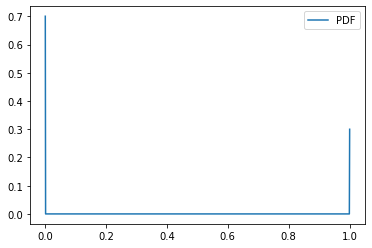

In [ ]:
data = Y_list
count, bins_count = np.histogram(data, bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, label="PDF")
plt.legend()
plt.show()

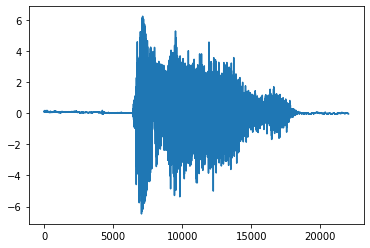

In [ ]:
plt.plot(X_list[0,:,0])
plt.show()

# MetforNet Splitting Train-Validation-Test Data

In [ ]:
X = X_list
y = Y_list
skf = StratifiedKFold(n_splits=10, random_state = random_seed, shuffle=True)
skf.get_n_splits(X, y)
print(skf)  
FoldIndicesList = []
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    FoldIndicesList.append((train_index,test_index))
FoldIndicesList = np.asarray(FoldIndicesList)
np.save('./FoldIndicesList',FoldIndicesList)
FoldIndicesList = np.load('./FoldIndicesList.npy',allow_pickle=True)

StratifiedKFold(n_splits=10, random_state=34, shuffle=True)
TRAIN: [   0    1    2 ... 9769 9770 9771] TEST: [  18   21   27   35   70   89   90   95  103  106  112  117  121  147
  174  176  183  188  223  224  227  230  242  267  290  296  331  342
  366  367  369  370  380  387  388  392  393  397  401  404  422  424
  428  442  455  464  465  477  479  489  497  502  503  517  529  539
  545  547  548  553  556  562  566  576  577  588  620  674  678  706
  725  740  751  752  759  763  774  777  780  793  795  807  834  837
  853  854  858  863  887  907  928  934  951  953  954  988 1004 1014
 1015 1016 1035 1038 1046 1067 1080 1087 1090 1093 1097 1111 1144 1147
 1150 1176 1181 1193 1204 1211 1222 1231 1234 1239 1244 1251 1253 1255
 1258 1260 1291 1296 1314 1315 1318 1323 1344 1348 1364 1368 1393 1404
 1418 1426 1434 1435 1442 1455 1479 1481 1489 1493 1496 1509 1516 1525
 1528 1529 1542 1550 1576 1580 1596 1623 1624 1632 1647 1657 1675 1679
 1704 1708 1726 1748 1755 1757 1762 177

<ipython-input-33-91bca853af3e>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  FoldIndicesList = np.asarray(FoldIndicesList)


In [ ]:
FoldIndicesList.shape

(10, 2)

# MetforNet Architecture

In [ ]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs): 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform') 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer) 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint) 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint) 
            self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint) 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W) 
        if self.bias:
            uit += self.b 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u) 
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [ ]:
#model structure
def MetforNet121(length):
  
    main_input = Input(shape=(length,1), dtype='float32', name='main_input')
    x = Convolution1D(12, 3, padding='same')(main_input)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 48, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    cnnout = Dropout(0.2)(x)
    x = Bidirectional(GRU(12,return_sequences=True,return_state=False))(cnnout)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    main_output = Dense(1,activation='sigmoid')(x)

    return Model(inputs=main_input, outputs=main_output)
model = MetforNet121(5513)
print(model.summary())

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 5513, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 5513, 12)          48        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5513, 12)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5513, 12)          444       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5513, 12)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2757, 12)          3468      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2757, 12)          0     

In [ ]:
#model structure
def MetforNet(length, model):  
    main_input2 = Input(shape=(27,), dtype='float32', name='main_input2')
    x = model.layers[-2].output
    x = Concatenate(axis = -1)([x, main_input2])
    x = Dense(24,activation=None)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Dense(1,activation='tanh')(x)
    main_output = Add()([x, model.layers[-1].output])

    return Model(inputs=[model.input, main_input2], outputs=[main_output, model.layers[-1].output])
model = MetforNet(5513,MetforNet121(5513))
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 5513, 1)]    0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 5513, 12)     48          ['main_input[0][0]']             
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 5513, 12)     0           ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 5513, 12)     444         ['leaky_re_lu_17[0][0]']         
                                                                                            

# MetforNet Model Training and 10-fold Cross Validation



In [ ]:
#10-fold training
FoldIndicesList = np.load('./FoldIndicesList.npy',allow_pickle=True)
lr = 0.001
for i in range(10):
    model_name = 'CODA_PID_10dense_50folds_sigmoid_fold_double_separate_'+str(i)
    x_train_from_train = X_list[np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
    x_val_from_train = X_list[FoldIndicesList[i-1][1]]
    x_train_from_train_label = X_list_label[np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
    x_val_from_train_label = X_list_label[FoldIndicesList[i-1][1]]
    y_train_from_train = Y_list[np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
    y_val_from_train = Y_list[FoldIndicesList[i-1][1]]
    pre_model = MetforNet121(22050)
    model = MetforNet(22050,pre_model)

    opt = keras.optimizers.Adam(lr=lr)
    model.compile(loss=mean_squared_error,
                optimizer=opt,
                metrics=['accuracy'])
    checkpointer = ModelCheckpoint('./double_separate/'+model_name, verbose=1, save_best_only=True)
    model_history = model.fit( [x_train_from_train, x_train_from_train_label], [y_train_from_train,y_train_from_train],
                            batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                            validation_data=([x_val_from_train, x_val_from_train_label], [y_val_from_train,y_val_from_train]))
    with open('./double_separate/'+model_name+'_history.pickle', 'wb') as file:
        pickle.dump(model.history.history, file)


In [ ]:
AUCScores = []
AUCScores2 = []
for i in tqdm(range(10)):
  pre_model = MetforNet121(22050)
  model = MetforNet(22050, pre_model)
  model.load_weights('./double_separate/CODA_PID_10dense_50folds_sigmoid_fold_double_separate_'+str(i))
  out_name = keras_2_onnx(model, './double_separate/CODA_PID_10dense_50folds_sigmoid_fold_double_separate_'+str(i))
  predicted_val, predicted_val2 = get_prediction([X_list[FoldIndicesList[i][1]], X_list_label[FoldIndicesList[i][1]]], './double_separate/CODA_PID_10dense_50folds_sigmoid_fold_double_separate_'+str(i))
  AUCScores.append(roc_auc_score((Y_list[FoldIndicesList[i][1]]>0.5), predicted_val[:,0]))
  AUCScores2.append(roc_auc_score((Y_list[FoldIndicesList[i][1]]>0.5), predicted_val2[:,0]))


 10%|█         | 1/10 [00:21<03:16, 21.83s/it]/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
 20%|██        | 2/10 [00:43<02:52, 21.58s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseede

In [ ]:
predicted_val.shape, predicted_val2.shape

((977, 1), (977, 1))

In [ ]:
print('AUCScores 1')
print(AUCScores)
print("Median AUC: ", np.median(AUCScores))
print("Mean AUC: ", np.mean(AUCScores))

AUCScores 1
[0.8864104033282678, 0.8651702747813955, 0.8782358341815859, 0.8745334610701955, 0.8754016725545376, 0.8782458136239346, 0.8758307885755345, 0.8766291439634353, 0.8813194818673531, 0.8791988503682415]
Median AUC:  0.8774324890725106
Mean AUC:  0.8770975724314483


In [ ]:
print('AUCScores 2')
print(AUCScores2)
print("Median AUC: ", np.median(AUCScores2))
print("Mean AUC: ", np.mean(AUCScores2))

AUCScores 2
[0.7092349468124859, 0.7006701377643806, 0.7076921541624254, 0.6919994810689979, 0.6894148055006687, 0.7209847713709758, 0.7031215695666926, 0.7095283715545975, 0.7283096820549668, 0.7303854060635092]
Median AUC:  0.7084635504874557
Mean AUC:  0.7091341325919701


In [ ]:
main_input = Input(shape=(22050,1), dtype='float32', name='main_input')  
main_input2 = Input(shape=(27,), dtype='float32', name='main_input2')
outputs = []
for i in tqdm(range(10)):
  pre_model = MetforNet121(22050)
  model = MetforNet(22050, pre_model)
  model.load_weights('./double_separate/CODA_PID_10dense_50folds_sigmoid_fold_double_separate_'+str(i))
  model.layers.pop(0)
  newOutputs = model([main_input, main_input2])
  outputs.append(newOutputs)
main_output = Average(name='output')([i[0] for i in outputs])
main_output2 = Average(name='output2')([i[1] for i in outputs])
fin_model = Model(inputs=[main_input, main_input2], outputs=[main_output, main_output2])
print(fin_model.summary())

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 22050, 1)]   0           []                               
                                                                                                  
 main_input2 (InputLayer)       [(None, 27)]         0           []                               
                                                                                                  
 model_24 (Functional)          [(None, 1),          28826       ['main_input[0][0]',             
                                 (None, 1)]                       'main_input2[0][0]']            
                                                                                                  
 model_26 (Functional)          [(None, 1),          28826       ['main_input[0][0]',      

In [ ]:
out_name = keras_2_onnx(fin_model, './double_separate/model')
predicted_val = np.zeros(Y_list.shape)
for i in tqdm(range(predicted_val.shape[0])):
  predicted_temp = get_prediction2([X_list[i:i+1,:], X_list_label[i:i+1,:]], './double_separate/model')
  predicted_val[i] += predicted_temp[0,0]

100%|██████████| 9772/9772 [1:41:38<00:00,  1.60it/s]


In [ ]:
roc_auc_score((Y_list>0.5), predicted_val)

0.9142044269833083

In [ ]:
predicted_val2 = predicted_val.copy()
predicted_val2[predicted_val2<0] = 0
predicted_val2[predicted_val2>=1] = 1

In [ ]:
roc_auc_score((Y_list>0.5), predicted_val2)

0.9141497556250144

# Create requirements.txt

In [7]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

In [8]:
!ls

requirements.txt  sample_data


# Inference code

In [ ]:
#!/usr/bin/env python
import onnxruntime as rt
import pandas as pd
import numpy as np
import soundfile as sf


def prediction(input_path, model_path):	
    switch = 1
    AllCol = ['participant', 'filename', 'age', 'height', 'weight',
          'reported_cough_dur', 'heart_rate', 'temperature', 'sex_Female',
          'sex_Male', 'tb_prior_No', 'tb_prior_Not sure', 'tb_prior_Yes',
          'tb_prior_Pul_No', 'tb_prior_Pul_Yes', 'tb_prior_Extrapul_No',
          'tb_prior_Extrapul_Yes', 'tb_prior_Unknown_No',
          'tb_prior_Unknown_Yes', 'hemoptysis_No', 'hemoptysis_Yes',
          'weight_loss_No', 'weight_loss_Yes', 'smoke_lweek_No',
          'smoke_lweek_Yes', 'fever_No', 'fever_Yes', 'night_sweats_No',
          'night_sweats_Yes']
    CODAMuStd = np.asarray([[ 40.817745 , 161.45787  ,  57.327652 ,  46.227486 ,  87.421104 ,
            36.733143 ],
          [ 15.1564245,   8.7601595,  13.59417  ,  51.92165  ,  16.980263 ,
              0.5627685]])
    input_df = pd.read_csv(input_path+'meta_info.csv')[['participant', 'filename']]
    X_list_label = np.zeros((input_df.shape[0], 27))

    try:
        input_df2 = pd.read_csv(input_path+'CODA_TB_Clinical_Meta_Info_Test.csv')
        input_df3 = pd.merge(input_df2, input_df, on="participant")
        numerical = input_df3[['filename', 'participant', 'age', 'height', 'weight', 'reported_cough_dur', 'heart_rate',
            'temperature']].copy()
        categorical = input_df3[['sex', 'tb_prior', 'tb_prior_Pul',
            'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis', 'weight_loss', 'smoke_lweek', 'fever', 'night_sweats', 'participant']].copy()
        categorical = pd.get_dummies(categorical).copy()
        categorical['filename'] = input_df3['filename']
        input_df3 = pd.merge(numerical, categorical, on="filename")
        temp = input_df3[['participant', 'filename']].copy()
        input_df = temp
        
        switch = 0        
        for i in range(6):
            try:
                input_df3[AllCol[2:][i]] = (input_df3[AllCol[2:][i]].astype('float32')-CODAMuStd[0, i])/CODAMuStd[1, i]
                input_df3[AllCol[2:][i]] = input_df3[AllCol[2:][i]].fillna(0).copy()
                temp = input_df3[AllCol[2:][i]].values
                X_list_label[:, i] += temp
            except:
                X_list_label[:, i] = np.zeros(X_list_label.shape[0])
                
        for i in range(21):
            try:
                temp = input_df3[AllCol[2:][i+6]].values
                X_list_label[:, i+6] += temp
            except:
                X_list_label[:, i+6] = np.zeros(X_list_label.shape[0])
    except:
        input_df = pd.read_csv(input_path+'meta_info.csv')[['participant', 'filename']]

    dataXList = input_df['filename'].values
    X_list = []
    for i in range(len(dataXList)):
        patient = np.zeros((22050,1), dtype=np.float32)
        rawValues, rate = sf.read(input_path+'raw_test_data/'+dataXList[i])
        mu = np.nanmean(rawValues)
        std = np.nanstd(rawValues)
        patient[-len(rawValues):, 0] = (rawValues-mu)/std
        X_list.append(patient)
    X_list = np.asarray(X_list)

    pred = np.zeros(X_list.shape[0])
    model_inference = rt.InferenceSession(model_path+'model.onnx')
    input_name = model_inference.get_inputs()[0].name
    input_name2 = model_inference.get_inputs()[1].name
    label_name = model_inference.get_outputs()[0].name
    label_name2 = model_inference.get_outputs()[1].name    
    for i in range(X_list.shape[0]):
        onnx_pred = model_inference.run([label_name, label_name2], {input_name: X_list[i:i+1, :].astype(np.float32), input_name2: X_list_label[i:i+1, :].astype(np.float32)})
        pred[i] += onnx_pred[switch][0, 0]

    #Paitent id
    df_pred = pd.DataFrame(input_df['participant'], columns=['participant']) 
    df_pred['probability'] = pred
    df_pred_temp = df_pred.dropna().groupby('participant')['probability'].max()
    df_pred_temp_values = df_pred_temp.values
    df_pred_temp_values[df_pred_temp_values>=1] = 1
    df_pred_temp_values[df_pred_temp_values<0] = 0
    df_pred_fin = pd.DataFrame(np.asarray([df_pred_temp.index, df_pred_temp_values]).T, columns=['participant','probability'])
    df_pred_fin.to_csv('./output/predictions.csv', index=False)

    # comfirm that probability of predictions.csv exists
    print(pd.read_csv('./output/predictions.csv')['probability'])
    print('mode :', switch)


if __name__ == '__main__':    
    #holdout sample file path 
    input_path = './input/' # Utilize {'meta_info.csv'  'raw_test_data/*.wav'} according to your preprocessing logic
    # In SC2 you may also load CODA_TB_Clinical_Meta_Info_Test.csv
    # however attempting to load it in SC1 will result in failure
    
    #model path
    model_path = './model/'
    prediction(input_path, model_path)
